## UpGrad Assignment - Advanced Regression

- Uses Ridge & Lasso regularization techniques

In [2]:
%pip install -q numpy pandas matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
if os.name == 'nt':
  !mkdir data\original
  !curl.exe -o data/original/train.csv https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv
else:
  !mkdir ./data/original
  !wget -P ./data/original https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv

A subdirectory or file data\original already exists.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  449k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  4  449k    4 21036    0     0   5040      0  0:01:31  0:00:04  0:01:27  5043
  4  449k    4 21036    0     0   4061      0  0:01:53  0:00:05  0:01:48  4063
  4  449k    4 21036    0     0   3403      0  0:02:15  0:00:06  0:02:09  3772
  4  449k    4 21036    0     0   2946      0  0:02:36  0:00:07  0:02:29  3840
  8  449k    8 38444    0     0   4663      0  0:01:38  0:00:08  0:01:30  6723
  8  449k    8 38444    0     0   4156      0  0:01:50  0:00:09  0:01:41  342

In [5]:
df_data = pd.read_csv('./data/original/train.csv')
print(f"Dataset has {df_data.shape[0]} records with {df_data.shape[1]-2} features or columns with 1 target variable 'SalePrice'.\n")
df_data.info()

Dataset has 1460 records with 79 features or columns with 1 target variable 'SalePrice'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseS

In [6]:
ORDINAL_CATEGORICAL_FEATURES = ['MSSubClass', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'PoolQC']
NOMINAL_CATEGORICAL_FEATURES = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
BINARY_CATEGORICAL_FEATURES = ['CentralAir']

NUMERICAL_FEATURES = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

print(f"Out of total {len(ORDINAL_CATEGORICAL_FEATURES) + len(NOMINAL_CATEGORICAL_FEATURES) + len(BINARY_CATEGORICAL_FEATURES) + len(NUMERICAL_FEATURES)} features there are, \
      \n- {len(ORDINAL_CATEGORICAL_FEATURES)} Categorical Ordinal Featrues \
      \n- {len(NOMINAL_CATEGORICAL_FEATURES)} Categorical Nominal Featrues \
      \n- {len(BINARY_CATEGORICAL_FEATURES)} Categorical Binary Featrues \
      \n- {len(NUMERICAL_FEATURES)} Numerical Featrues")

Out of total 79 features there are,       
- 20 Categorical Ordinal Featrues       
- 25 Categorical Nominal Featrues       
- 1 Categorical Binary Featrues       
- 33 Numerical Featrues


### Data Quality Checks

- Identify missing values and treat them.

In [7]:
# Identify columns with null values
for column in list(df_data[NUMERICAL_FEATURES].columns[df_data[NUMERICAL_FEATURES].isna().any()]):
  print(f"{column}: {df_data[column].isna().sum()}")

LotFrontage: 259
MasVnrArea: 8
GarageYrBlt: 81


#### Univariate Analysis: Numerical features

When dealing with numerical variables, we have to check their properties like:

- Mean
- Median
- Standard Deviation
- Kurtosis/skewness
- distribution/range

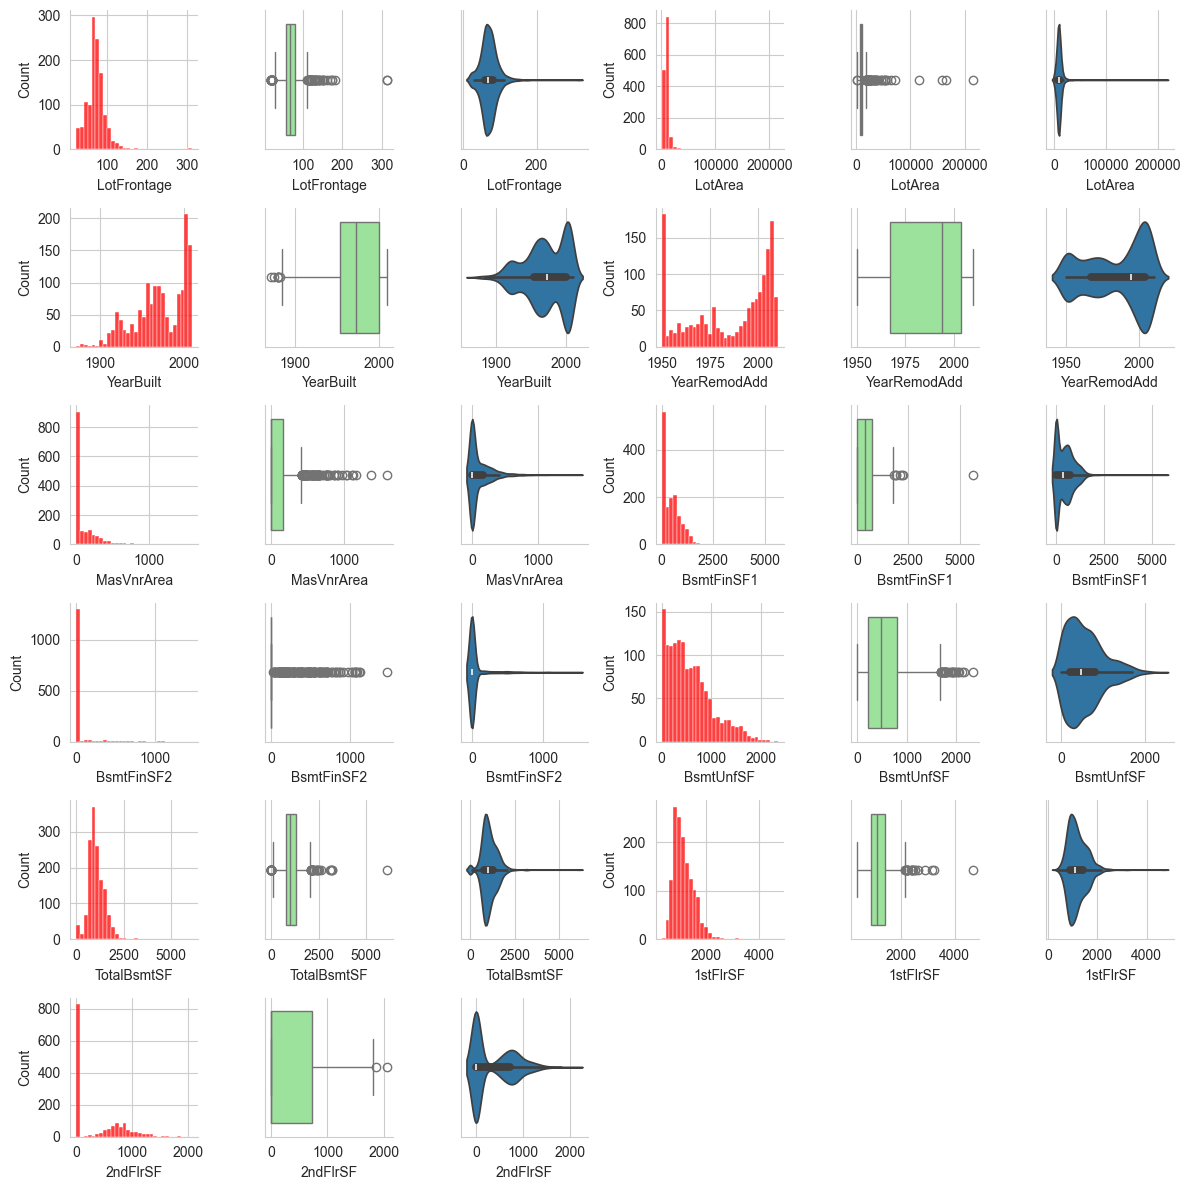

In [54]:
sns.set_style('whitegrid')

num_plots_in_a_row = 6   # No. of plots in every row
num_of_plot_rows = math.ceil(len(NUMERICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(NUMERICAL_FEATURES), col=0, col_wrap=6, height=2, sharex=False, sharey=False)
for i, feature in enumerate(NUMERICAL_FEATURES):
    # If not enough features, move on.
    if i*3 >= len(grid.axes):
        break
    axes = sns.histplot(df_data, x=feature, kde = False, color ='red', bins=30, ax=grid.axes[i*3 + 0])
    axes.set_title(None)
    axes = sns.boxplot(df_data, x=feature, color ='lightgreen', ax=grid.axes[i*3 + 1])
    axes.set_title(None)
    axes = sns.violinplot(data=df_data, x=feature, ax=grid.axes[i*3 + 2])
    axes.set_title(None)

grid.tight_layout()
plt.show()




#### Summary of Univariate Analysis: Numerical Features

- `` has outliers.
- `` 

##### Univariate Analysis: Categorical Features

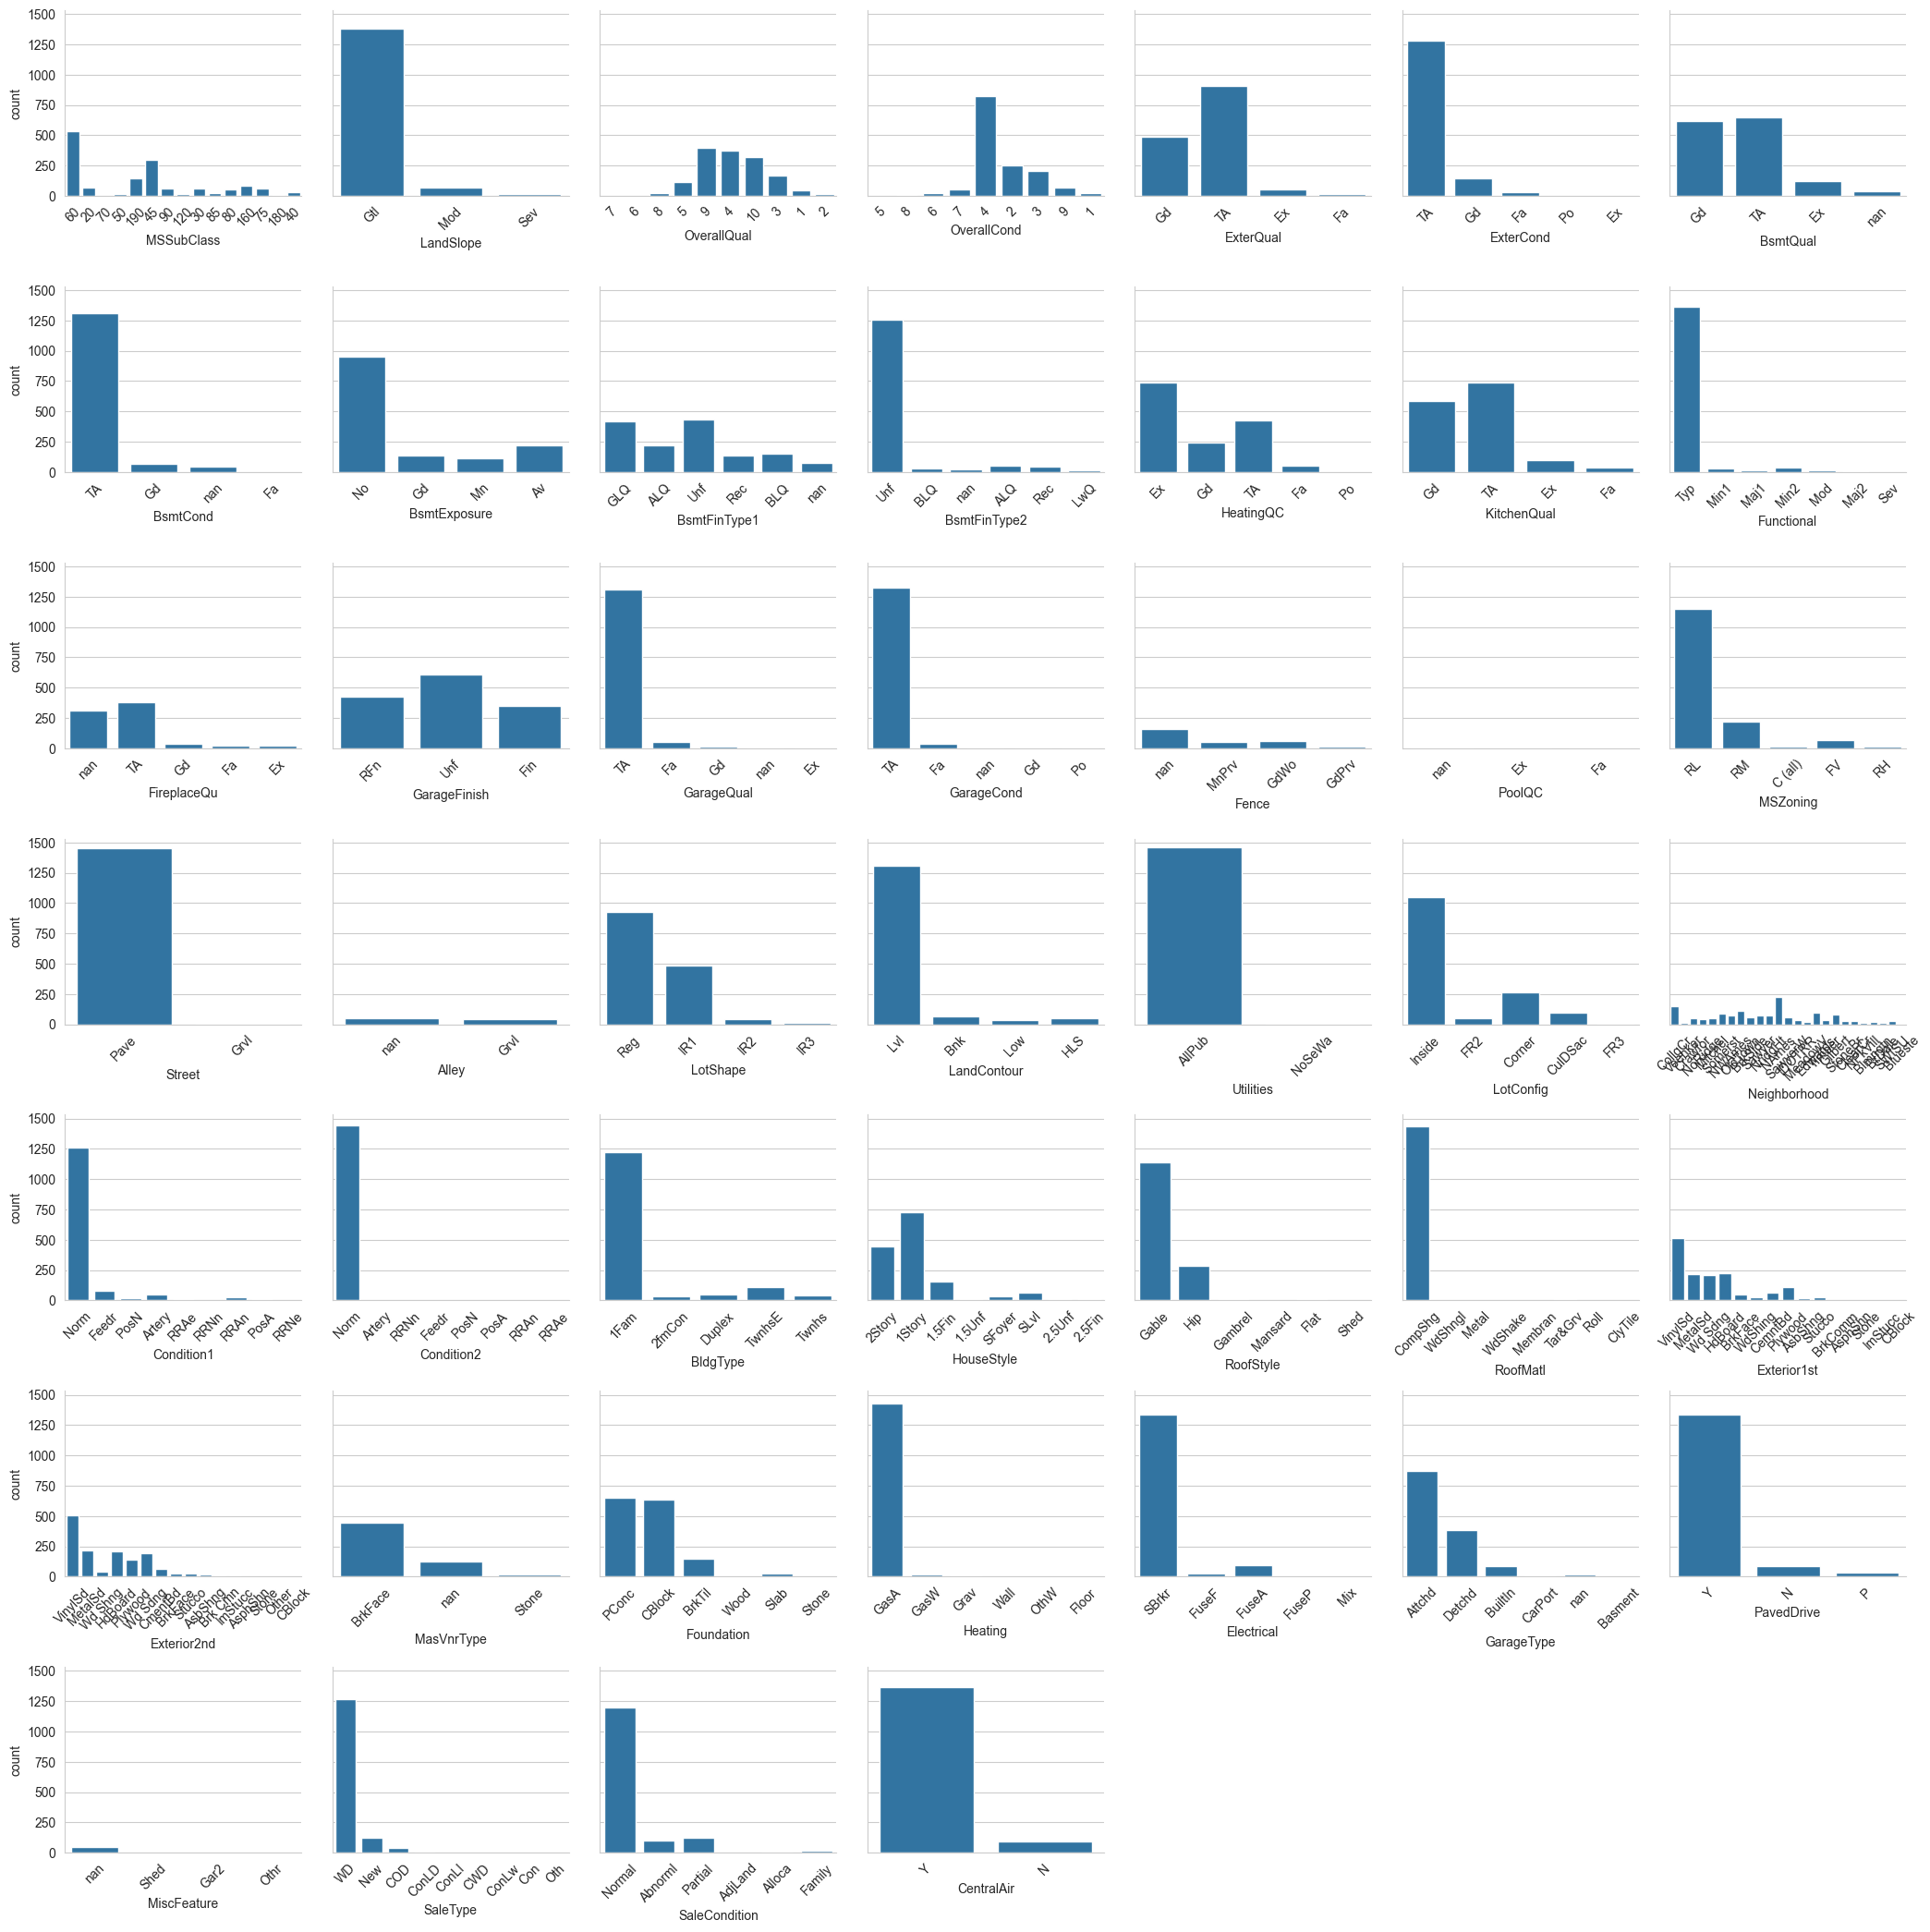

In [41]:

import warnings
warnings.filterwarnings('ignore')

num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES + BINARY_CATEGORICAL_FEATURES))/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES + BINARY_CATEGORICAL_FEATURES)), col=0, col_wrap=7, height=3, sharey=True, sharex=False, margin_titles=False)
for axs, feature in zip(grid.axes, list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES + BINARY_CATEGORICAL_FEATURES)):
    axes = sns.countplot(df_data, x=feature, ax=axs)
    axes.set_title(None)
    axes.set_xticklabels(labels=df_data[feature].unique(), rotation=45)

grid.tight_layout()
plt.show()

#### Summary of Univariate Analysis: Categorical Features



#### Bivariate Analysis

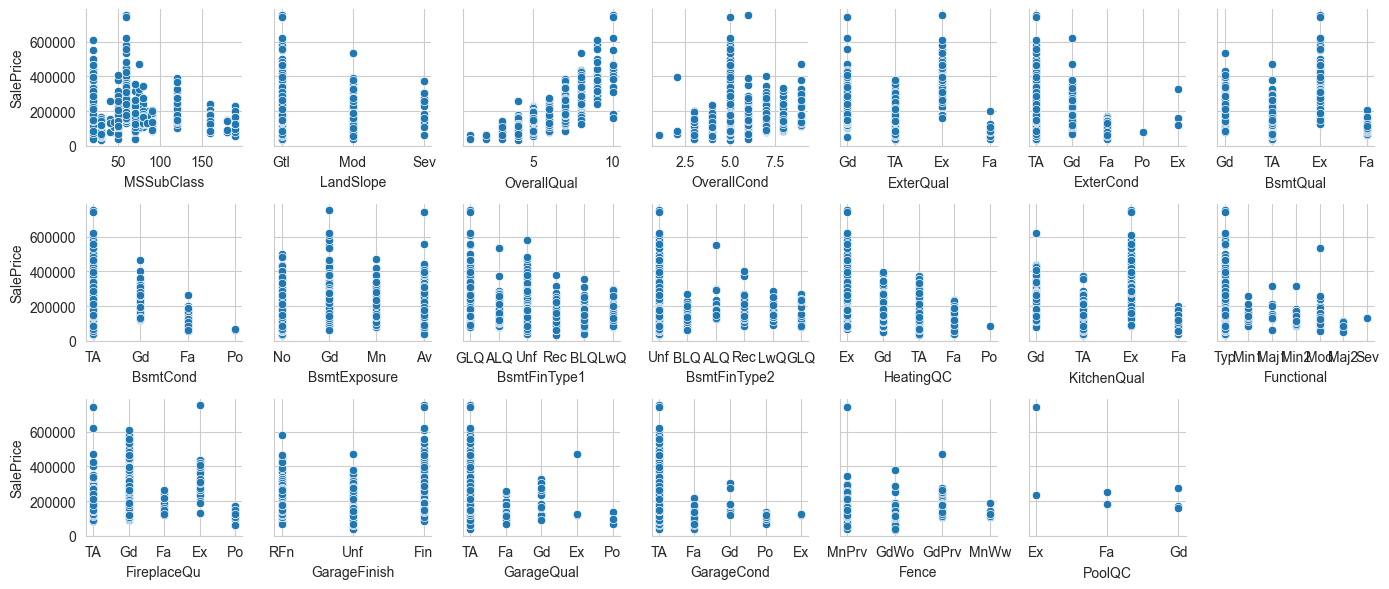

In [44]:
num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(ORDINAL_CATEGORICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(ORDINAL_CATEGORICAL_FEATURES), col=0, col_wrap=7, height=2, sharex=False)
for ax, feature in zip(grid.axes, ORDINAL_CATEGORICAL_FEATURES):
    axes = sns.scatterplot(data=df_data, x=feature, y='SalePrice', ax=ax)
    axes.set_title(None)
    
grid.tight_layout()
plt.show()

### Multivariate Analysis

### Category Variables Processing
